In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from google.colab import drive
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
torch.cuda.is_available()
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#get datapath
train_path = '/content/gdrive/My Drive/split_data/train'
val_path = '/content/gdrive/My Drive/split_data/val'
test_path = '/content/gdrive/My Drive/split_data/test'

transform = transforms.Compose([transforms.ToTensor()])

#load data from datapath
train_set = torchvision.datasets.ImageFolder(train_path, transform=transform)
val_set = torchvision.datasets.ImageFolder(val_path, transform=transform)
test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
print(test_set.class_to_idx)
test_loader = DataLoader(test_set, batch_size = 32, shuffle=False)
print("The length of train set: {}".format(len(train_set)))
print("The length of validation set: {}".format(len(val_set)))
print("The length of test set: {}".format(len(test_set)))

#dataloader
def get_dataloader(batch_size):
  train_loader = DataLoader(train_set, batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size, shuffle=False)
  test_loader = DataLoader(test_set, batch_size, shuffle=False)
  return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = get_dataloader(batch_size=32)
classes = ['beaware', 'bike', 'makeway', 'nochange', 'nodrive', 'nohonk', 'noleft', 'nopark', 'nostraight','noturn','pushtoright','railroadahead',
           'school', 'speed5', 'speed30', 'speed40', 'speed50', 'speed60', 'speed70', 'speed80', 'stop', 'stop_noword', 'turnright']

{'beaware': 0, 'bike': 1, 'makeway': 2, 'nochange': 3, 'nodrive': 4, 'nohonk': 5, 'noleft': 6, 'nopark': 7, 'nostraight': 8, 'noturn': 9, 'pushtoright': 10, 'railroadahead': 11, 'school': 12, 'speed30': 13, 'speed40': 14, 'speed5': 15, 'speed50': 16, 'speed60': 17, 'speed70': 18, 'speed80': 19, 'stop': 20, 'stop_noword': 21, 'turnright': 22}
The length of train set: 1856
The length of validation set: 23
The length of test set: 417


In [ ]:
import shutil
from sklearn.model_selection import train_test_split
import os
data_dir = '/content/gdrive/My Drive/split_data/train'
output_dir = '/content/gdrive/MyDrive/DemoTest'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'valcnn')
test_dir = os.path.join(output_dir, 'Testcnn')

# define the folder
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = os.listdir(data_dir)
train_loader, val_loader, test_loader = get_dataloader(1)
classes = ['beaware', 'buke', 'makeway', 'nochange', 'nodrive', 'nohonk', 'noleft', 'nopark', 'nostraight','noturn','pushtoright','railroadahead',
           'school', 'speed5', 'speed30', 'speed40', 'speed50', 'speed60', 'speed70', 'speed80', 'stop', 'stop_noword', 'turnright']

In [ ]:
import torchvision.models as models
vgg = models.vgg16(pretrained=True)
vgg_features = nn.Sequential(*list(vgg.features))  # Remove Fc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]


In [ ]:
torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.layer1 = nn.Linear(3 * 160 * 149, 500)
        self.layer2 = nn.Linear(500, 100)
        self.layer3 = nn.Linear(100, 23)
    def forward(self, img):
        flattened = img.view(-1, 3 * 160 * 149)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)

        return activation3


In [ ]:
def get_accuracy(model, smalldata):
    data = smalldata

    correct = 0
    total = 0
    for imgs, labels in data:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available(): #set that i want use gpu and check the gpu is available
          imgs = imgs.cuda() #cpu to gpu
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item() #compare label
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, train_loader, val_loader, batch_size=32, lr = 0.001, num_epochs=1):
    #train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
    train_loader, val_loader, test_loader = get_dataloader(batch_size)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    epoch = 0
    for epoch in range(num_epochs):
        print('PROGRESS {}%'.format(epoch*10))
        for imgs, labels in iter(train_loader):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        n += 1
        epoch += 1
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Loss:{}".format(losses[-1]))

In [ ]:
use_cuda = 1
model = ANN()
if use_cuda and torch.cuda.is_available():
  model.cuda() #model on gpu
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_loader, val_loader, batch_size=32, lr = 0.001, num_epochs=25)

In [ ]:
train_loader, val_loader, test_loader = get_dataloader(batch_size=32)

In [ ]:
get_accuracy(model, test_loader)

In [ ]:
print("Final Training Accuracy: {}".format(train_acc[-1]))

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/TrainedANN.pth')

In [ ]:
use_cuda = 1
testmodel = ANN()
testmodel.load_state_dict(torch.load('/content/gdrive/My Drive/TrainedANN.pth'))

<ipython-input-27-2c701bf7590c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel.load_state_dict(torch.load('/content/gdrive/My Drive/TrainedANN.pth'))


<All keys matched successfully>

In [ ]:
get_accuracy(model, test_loader)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
train_loader, val_loader, test_loader = get_dataloader(batch_size=32)
def confusiontrain(model, data, batch_size=256, num_epochs=20, learning_rate=0.001):

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # visualize
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= ['beaware', 'buke', 'makeway', 'nochange', 'nodrive', 'nohonk', 'noleft', 'nopark', 'nostraight','noturn','pushtoright','railroadahead',
          'school', 'speed5', 'speed30', 'speed40', 'speed50', 'speed60', 'speed70', 'speed80', 'stop', 'stop_noword', 'turnright'], yticklabels=['beaware', 'buke', 'makeway', 'nochange', 'nodrive', 'nohonk', 'noleft', 'nopark', 'nostraight','noturn','pushtoright','railroadahead',
          'school', 'speed5', 'speed30', 'speed40', 'speed50', 'speed60', 'speed70', 'speed80', 'stop', 'stop_noword', 'turnright'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Baseline Model Confusion Matrix')
    plt.savefig('final_confusion_matrix.png')
    plt.show()

    print('Finished Training')


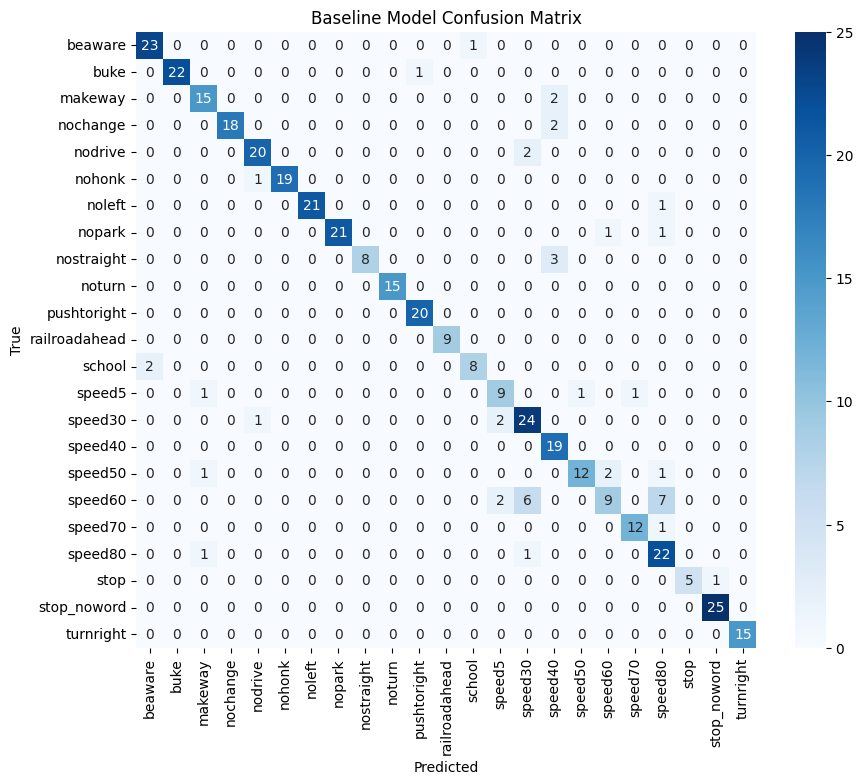

Finished Training


In [ ]:
confusiontrain(testmodel,test_loader, batch_size=256, num_epochs=20, learning_rate=0.001)

In [ ]:
val_loader = DataLoader(val_set, batch_size = 1, shuffle=False)
for imgs, labels in val_loader:
  probs = model(imgs)
  probabilities = torch.softmax(probs, dim=1)

  max_prob, predicted_class = torch.max(probabilities, dim=1)
  if classes[predicted_class] != 'speed60':
    print('wrong', classes[predicted_class])
  else:
    print('right',classes[predicted_class])

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.name = "cnn_model"
    self.conv1 = nn.Conv2d(512, 256, 2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(256, 10, 2)
    self.fc1 = nn.Linear(10 * 1 * 1, 128)
    self.fc2 = nn.Linear(128, 23)

  def forward(self, x):

      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 10 * 1 * 1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      x = x.squeeze(1)
      return x

In [ ]:
def train(model, data, batch_size=256, num_epochs=20, learning_rate = 0.001):

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss() # for multi-class classfaction
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # Train the network
    start_time = time.time()
    n = 0
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, (imgs, labels) in enumerate(train_loader):
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()


          out = model(imgs)
          loss = criterion(out, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)             # compute *average* loss
          # print(out.shape)
          # print(labels.shape)
          pred_classes = out.argmax(dim=1)
          corr = pred_classes != labels
          # corr = (out > 0.0).squeeze().long() != labels
          total_train_err += int(corr.sum())
          total_train_loss += loss.item()
          total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        train_acc.append(get_accuracy(model, batch_size=batch_size, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, batch_size=batch_size, train=False))  # compute validation accuracy
        n += 1

        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {} |" +
               "Train acc: {} |"+"Validation acc: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch],
                   train_acc[-1],
                   val_acc[-1]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    epochs = np.arange(1, num_epochs + 1)
    # model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    plot_training_curve(model_path)

CUDA is available!  Training on GPU ...


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample = self.loader(path)


Epoch 1: Train err: 0.859375, Train loss: 2.9298035800457 |Validation err: 0.6838046272493573, Validation loss: 0.013219194730940086 |Train acc: 0.3098060344827586 |Validation acc: 0.3161953727506427
Epoch 2: Train err: 0.5646551724137931, Train loss: 2.1976298093795776 |Validation err: 0.3676092544987147, Validation loss: 0.009129129522563865 |Train acc: 0.6497844827586207 |Validation acc: 0.6323907455012854
Epoch 3: Train err: 0.27478448275862066, Train loss: 1.3029027059674263 |Validation err: 0.20565552699228792, Validation loss: 0.005265390658439891 |Train acc: 0.8205818965517241 |Validation acc: 0.794344473007712
Epoch 4: Train err: 0.1320043103448276, Train loss: 0.6562464199960232 |Validation err: 0.09254498714652956, Validation loss: 0.00262647193011404 |Train acc: 0.9299568965517241 |Validation acc: 0.9074550128534704
Epoch 5: Train err: 0.06303879310344827, Train loss: 0.3039354030042887 |Validation err: 0.03598971722365039, Validation loss: 0.0014170620849016087 |Train acc:

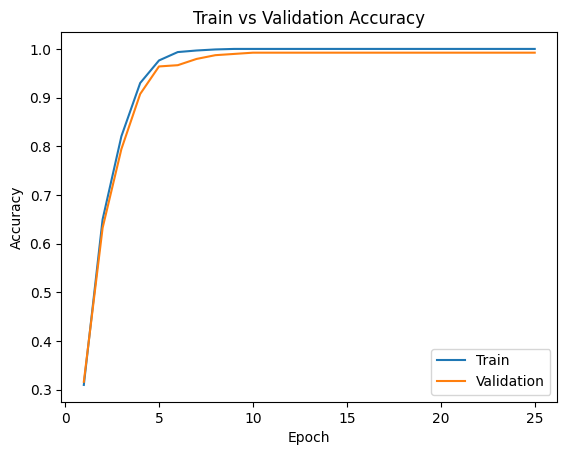

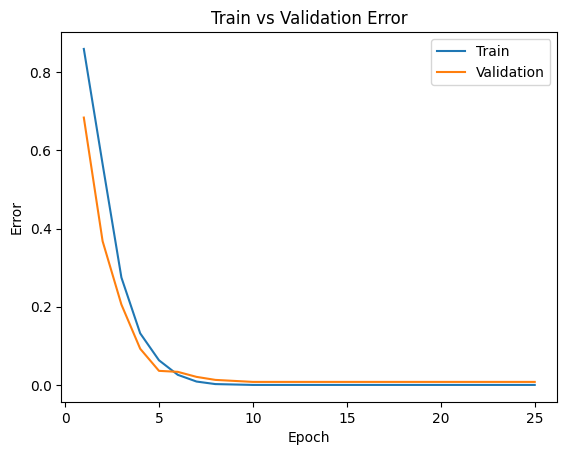

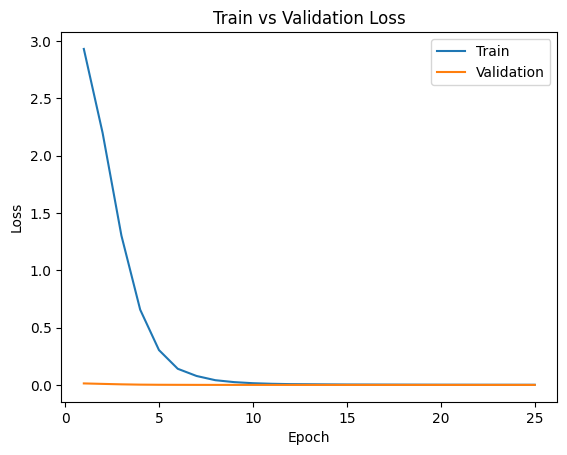

In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_dataset, batch_size=256, learning_rate=0.001, num_epochs=25)

In [ ]:
model = CNN()
# model.load_state_dict(torch.load('/content/gdrive/My Drive/TrainedCNN.pth'), map_location=torch.device('cpu'))
model.load_state_dict(torch.load('/content/gdrive/My Drive/TrainedCNN.pth', map_location=torch.device('cpu')))

<ipython-input-30-140fa6405433>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/gdrive/My Drive/TrainedCNN.pth', map_location=tor

<All keys matched successfully>

In [ ]:
transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


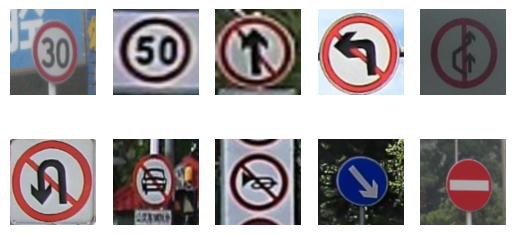

In [ ]:
test_path = '/content/gdrive/My Drive/DemoTest/Random'
test_Demo = torchvision.datasets.ImageFolder(test_path, transform=transform)
test_load = DataLoader(test_Demo, batch_size = 1, shuffle=False)
k = 0
for images, labels in test_load:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]

    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1


In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
test_set = torchvision.datasets.ImageFolder(test_path, transform=transform)
test_loader = DataLoader(test_set, batch_size = 1, shuffle=False)

In [ ]:
def compute_features(loader,path):
  # split the data

  # determin the category of data
  n = 0
  for imgs, labels in loader:
    category_path = os.path.join(path, str(classes[labels]))
    if not os.path.isdir(category_path):
      os.makedirs(category_path)
    features = vgg_features(imgs)
    tensor = torch.from_numpy(features.detach().numpy())
    torch.save(tensor.squeeze(0), os.path.join(category_path, str(n) + '.tensor' ))
    n += 1

In [ ]:
test_path = '/content/gdrive/My Drive/DemoTest/Testcnn'
test_set = torchvision.datasets.DatasetFolder(test_path,loader=torch.load, extensions= '.tensor')
print(test_set[1])


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/folder.py:245: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample = self.loader(path)


(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.1931,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.2236, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0286, 0.4550, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.5045,  ..., 1.2347, 0.5071, 0.0000],
         [0.7436, 0.2792, 0.0000,  ..., 0.0000, 0.6938, 0.8304],
         [0.9635, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

In [ ]:
test_loader = DataLoader(test_set, batch_size = 1, shuffle=False)
for imgs, labels in test_loader:

  probs = model(imgs)

  probabilities = torch.softmax(probs, dim=1)

        # extract the max probs
  max_prob, predicted_class = torch.max(probabilities, dim=1)

  print(classes[predicted_class])

speed30
speed50
nostraight
noleft
nochange
noleft
nodrive
nohonk
pushtoright
stop_noword


In [ ]:
confusiontrain(model,test_loader, batch_size=256, num_epochs=20, learning_rate=0.001)

In [ ]:
test_loader = DataLoader(test_set, batch_size = 1, shuffle=False)
for imgs, labels in test_loader:
  print(labels)
  imgs = vgg_features(imgs)
  tensor = torch.from_numpy(imgs.detach().numpy())

  probs = model(tensor.squeeze(0))
  probabilities = torch.softmax(probs, dim=1)


  max_prob, predicted_class = torch.max(probabilities, dim=1)
  print(classes[predicted_class])
  break

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (11718/11718), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 25.0 MB/s eta 0:00:00


In [ ]:
!unzip -q /content/drive/MyDrive/smldata.zip -d /content/drive/MyDrive

In [ ]:
!cp -r /content/drive/MyDrive/smldata /content/yolov5

In [ ]:
!python /content/yolov5/train.py --img 416 --batch 64 --epochs 50 --data /content/yolov5/smldata/YOLOv5_TT100K.yaml --weights yolov5s.pt

In [ ]:
!cp /content/drive/MyDrive/5749.jpg /content/yolov5

In [ ]:
!python /content/yolov5/detect.py \
--weights /content/yolov5/best.pt \
--source /content/yolov5/5749.jpg \
--img 416 \
--conf 0.2

detect: weights=['/content/yolov5/best.pt'], source=/content/yolov5/5749.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7144975 parameters, 0 gradients, 16.2 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/yolov5/5749.jpg: 416x416 1 no left, 7.3ms
Speed: 0.4ms pre-process, 7.3ms inference, 558.5ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp10
